<a href="https://colab.research.google.com/github/Atk2045/data_bootcamp_final/blob/main/Ali_Tamer_MT_Data_bootcamp_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What Makes a Winner in the Premier League? Analyzing Key Performance and Financial Factors ⚽️

**Introduction and Motivation:**

---


With players from all over the world, the Premier League can be considered one of the most competitive leagues in the world. Multiple factors affect the football industry there which holds massive amounts of worldwide investments. A combination of off-field financial tactics (player expenditure) and on-field performance (goals, shots, and fouls) influence the success in the PL. This project concentrates on key metrics that could help clubs move up the league rankings by examining the factors that most influence team success. In an effort to help other teams follow in their footsteps, using this analysis I will try to find strategies for teams hoping to compete with and possibly surpass, dominant clubs like Manchester City, who won the title in both of the analyzed seasons 2020-21 and 2021-22.

After obtaining the dataset from Kaggle, which contains metrics based on fixtures, I combined the two seasons and made an aggregated standings leaderboard to test every metric on clubs level.


In [ ]:
# Import libraries
!pip install fuzzywuzzy
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
from fuzzywuzzy import fuzz, process
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 2020-2021.csv to 2020-2021 (1).csv
Saving 2021-2022.csv to 2021-2022 (1).csv


# **Research Questions**

**What Makes a Winner in the Premier League?**

To answer this question I will try to approach all 3 subquestions below:

1)Which in-game performance metrics—such as goals, shots, fouls, and corners—are most strongly correlated with winning? How does home vs. away performance impact these metrics?

2)How significant is the impact of yellow and red cards, and do referees indirectly influence match outcomes?

3)How crucial is financial investment, particularly in terms of expenditure, in determining league performance? Can strategic spending improve a team's chances of winning?

In [ ]:
relevant_columns = [
    'Div', 'Date', 'HomeTeam', 'AwayTeam',
    'FTHG', 'FTAG', 'FTR', 'HS', 'AS', 'HST', 'AST',
    'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A',
    'Referee', 'HC', 'AC', 'HF', 'AF'
]

data_2020_2021 = pd.read_csv('2020-2021.csv', usecols=relevant_columns)
data_2021_2022 = pd.read_csv('2021-2022.csv', usecols=relevant_columns)

# Add season labels and combine
data_2020_2021['Season'] = '2020-2021'
data_2021_2022['Season'] = '2021-2022'
seasons_dataset = pd.concat([data_2020_2021, data_2021_2022], ignore_index=True)

# Show first few rows of combined data
seasons_dataset.head()


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HS,AS,...,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,Season
0,E0,12/09/2020,Fulham,Arsenal,0,3,A,C Kavanagh,5,13,...,2,3,2,2,0,0,6.00,4.33,1.53,2020-2021
1,E0,12/09/2020,Crystal Palace,Southampton,1,0,H,J Moss,5,9,...,7,3,2,1,0,0,3.10,3.25,2.37,2020-2021
2,E0,12/09/2020,Liverpool,Leeds,4,3,H,M Oliver,22,6,...,9,0,1,0,0,0,1.28,6.00,9.50,2020-2021
3,E0,12/09/2020,West Ham,Newcastle,0,2,A,S Attwell,15,15,...,8,7,2,2,0,0,2.15,3.40,3.40,2020-2021
4,E0,13/09/2020,West Brom,Leicester,0,3,A,A Taylor,7,13,...,2,5,1,1,0,0,3.80,3.60,1.95,2020-2021


In [ ]:
# changes to the dataset for better readbility
seasons_dataset['Date'] = pd.to_datetime(seasons_dataset['Date'], format='%d/%m/%Y')
seasons_dataset['Goal Difference'] = seasons_dataset['FTHG'] - seasons_dataset['FTAG']
seasons_dataset['Total Shots'] = seasons_dataset['HS'] + seasons_dataset['AS']

In [ ]:
# Copying the existing code for match data and aggregations
standings_data = seasons_dataset.copy()

# Match points calculated and win percentage obtained
standings_data['Home Points'] = standings_data['FTR'].apply(lambda x: 3 if x == 'H' else (1 if x == 'D' else 0))
standings_data['Away Points'] = standings_data['FTR'].apply(lambda x: 3 if x == 'A' else (1 if x == 'D' else 0))
standings_data['Home Wins'] = standings_data['FTR'].apply(lambda x: 1 if x == 'H' else 0)
standings_data['Away Wins'] = standings_data['FTR'].apply(lambda x: 1 if x == 'A' else 0)
standings_data['Home Matches'] = 1
standings_data['Away Matches'] = 1
standings_data['Home Goals'] = standings_data['FTHG']
standings_data['Away Goals'] = standings_data['FTAG']

# Adding clean sheets calculations
standings_data['Home Clean Sheet'] = standings_data['FTAG'].apply(lambda x: 1 if x == 0 else 0)
standings_data['Away Clean Sheet'] = standings_data['FTHG'].apply(lambda x: 1 if x == 0 else 0)

# fixtures stats aggregated and table created
home_stats = standings_data.groupby('HomeTeam').agg({
    'Home Points': 'sum',
    'Home Wins': 'sum',
    'Home Matches': 'sum',
    'HY': 'sum',
    'HR': 'sum',
    'HS': 'sum',
    'HST': 'sum',
    'HF': 'sum',
    'HC': 'sum',
    'Home Goals': 'sum',
    'Home Clean Sheet': 'sum'  # Adding home clean sheets
}).rename(columns={
    'HY': 'Yellow Cards Home', 'HR': 'Red Cards Home', 'HS': 'Total Shots Home',
    'HST': 'Shots on Target Home', 'HF': 'Fouls Committed Home', 'HC': 'Corners Home'
})

away_stats = standings_data.groupby('AwayTeam').agg({
    'Away Points': 'sum',
    'Away Wins': 'sum',
    'Away Matches': 'sum',
    'AY': 'sum',
    'AR': 'sum',
    'AS': 'sum',
    'AST': 'sum',
    'AF': 'sum',
    'AC': 'sum',
    'Away Goals': 'sum',
    'Away Clean Sheet': 'sum'  # Adding away clean sheets
}).rename(columns={
    'AY': 'Yellow Cards Away', 'AR': 'Red Cards Away', 'AS': 'Total Shots Away',
    'AST': 'Shots on Target Away', 'AF': 'Fouls Committed Away', 'AC': 'Corners Away'
})

standings = home_stats.merge(away_stats, left_index=True, right_index=True, how='outer', suffixes=('_Home', '_Away')).fillna(0)

# All the metrics in the table calculated from points to all the other stats
standings['Total Clean Sheets'] = standings['Home Clean Sheet'] + standings['Away Clean Sheet']
standings['Total Points'] = standings['Home Points'] + standings['Away Points']
standings['Total Wins'] = standings['Home Wins'] + standings['Away Wins']
standings['Total Matches'] = standings['Home Matches'] + standings['Away Matches']

standings['Win Percentage'] = (standings['Total Wins'] / standings['Total Matches'] * 100).round(2)
standings['Home Win Percentage'] = (standings['Home Wins'] / standings['Home Matches'] * 100).round(2)
standings['Away Win Percentage'] = (standings['Away Wins'] / standings['Away Matches'] * 100).round(2)

standings['Total Yellow Cards'] = standings['Yellow Cards Home'] + standings['Yellow Cards Away']
standings['Total Red Cards'] = standings['Red Cards Home'] + standings['Red Cards Away']

standings['Total Shots'] = standings['Total Shots Home'] + standings['Total Shots Away']
standings['Total Shots on Target'] = standings['Shots on Target Home'] + standings['Shots on Target Away']

standings['Total Fouls Committed'] = standings['Fouls Committed Home'] + standings['Fouls Committed Away']
standings['Total Corners'] = standings['Corners Home'] + standings['Corners Away']

standings['Total Goals'] = standings['Home Goals'] + standings['Away Goals']
standings['Home Goals Percentage'] = (standings['Home Goals'] / standings['Total Goals'] * 100).round(2)
standings['Away Goals Percentage'] = (standings['Away Goals'] / standings['Total Goals'] * 100).round(2)

# Table created and order made and sorted by points like the actual aggregated leaderboard and displayed with Team as index
standings_table = standings[['Total Points', 'Win Percentage', 'Home Win Percentage', 'Away Win Percentage',
                             'Total Wins', 'Total Goals', 'Home Goals Percentage', 'Away Goals Percentage',
                             'Total Yellow Cards', 'Total Red Cards', 'Yellow Cards Home', 'Yellow Cards Away',
                             'Red Cards Home', 'Red Cards Away', 'Total Shots', 'Total Shots Home', 'Total Shots Away',
                             'Total Shots on Target', 'Total Fouls Committed', 'Fouls Committed Home', 'Fouls Committed Away',
                             'Total Corners', 'Corners Home', 'Corners Away', 'Home Clean Sheet', 'Away Clean Sheet', 'Total Clean Sheets']]

standings_table = standings_table.sort_values(by='Total Points', ascending=False)
standings_table.reset_index(inplace=True)
standings_table = standings_table.rename(columns={'index': 'Team'})
standings_table.index += 1
standings_table.head(23)


,HomeTeam,Total Points,Win Percentage,Home Win Percentage,Away Win Percentage,Total Wins,Total Goals,Home Goals Percentage,Away Goals Percentage,Total Yellow Cards,...,Total Shots on Target,Total Fouls Committed,Fouls Committed Home,Fouls Committed Away,Total Corners,Corners Home,Corners Away,Home Clean Sheet,Away Clean Sheet,Total Clean Sheets
1,Man City,179,73.68,73.68,73.68,56,182,55.49,44.51,88,...,473,681,341,340,564,311,253,21,19,40
2,Liverpool,161,63.16,65.79,60.53,48,162,48.15,51.85,90,...,470,759,376,383,545,292,253,17,16,33
3,Chelsea,141,52.63,47.37,57.89,40,134,50.75,49.25,111,...,420,842,434,408,469,254,215,16,18,34
4,Tottenham,133,52.63,60.53,44.74,40,137,53.28,46.72,120,...,374,825,447,378,363,192,171,15,13,28
5,Man United,132,48.68,50.00,47.37,37,130,53.85,46.15,139,...,399,847,388,459,396,208,188,11,10,21
6,Arsenal,130,52.63,55.26,50.00,40,116,50.86,49.14,107,...,349,708,369,339,417,243,174,11,14,25
7,West Ham,121,46.05,50.00,42.11,35,122,53.28,46.72,95,...,323,698,359,339,359,193,166,10,9,19
8,Leicester,118,44.74,50.00,39.47,34,130,52.31,47.69,114,...,354,772,388,384,399,205,194,12,6,18
9,Aston Villa,100,38.16,34.21,42.11,29,107,54.21,45.79,140,...,349,840,422,418,411,210,201,12,14,26
10,Everton,98,36.84,39.47,34.21,28,90,56.67,43.33,134,...,286,754,361,393,328,191,137,9,11,20


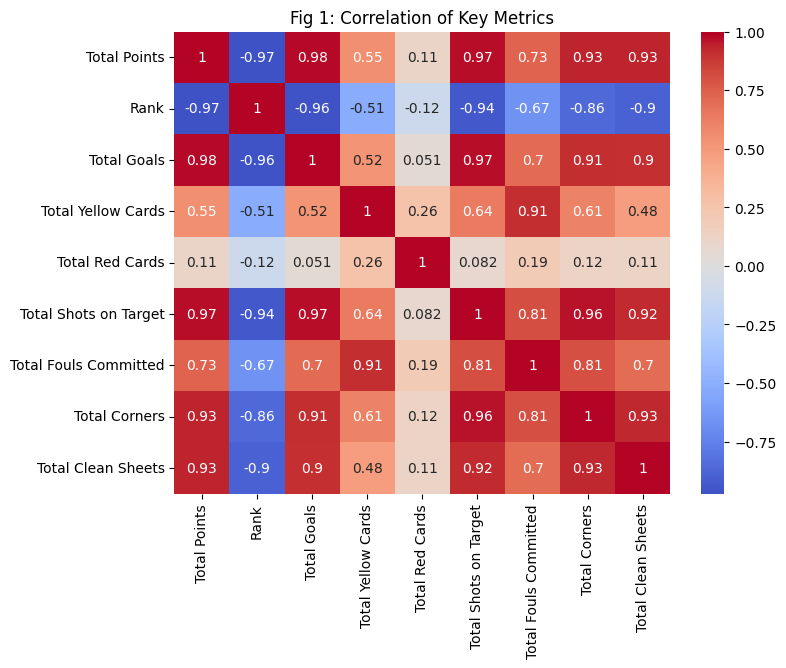

In [ ]:
# correlation metrics heatmap created to test all the correlations
standings_table['Rank'] = standings_table.index

corr_metrics = ['Total Points', 'Rank', 'Total Goals',
    'Total Yellow Cards', 'Total Red Cards', 'Total Shots on Target',
    'Total Fouls Committed', 'Total Corners','Total Clean Sheets']

correlation_data = standings_table[corr_metrics]
correlation_matrix = correlation_data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Fig 1: Correlation of Key Metrics')
plt.show()

## General Overview Using the Correlation Heatmap

As expected, given that *Total Goals* have a direct impact on match results, teams with more goals tend to gain more points. This is demonstrated by the strong correlation between *Total Goals* and *Total Points* (0.98).

Also, *Shots on Target* has a strong correlation with *Total Points* (0.97), indicating that a team's ability to score points is greatly influenced by its shooting accuracy (shots on target).

Teams that create more *Corner Opportunities* are generally more successful in terms of points, as shown by the strong positive correlation (0.93) between *Total Corners* and *Total Points*.

There is a moderately positive correlation (0.73) between *Total Fouls Committed* and *Total Points*. This could suggest that more competitive teams score more points because they frequently commit more fouls during offensive play. Also, defensively, *Total Clean Sheets* has a strong corellation (0.93) with *Total Points* shwoing the importance of defensive play

Teams may accrue more *Yellow Cards* as they play more competitively, according to the moderately positive correlation (0.55) between *Total Yellow Cards* and *Total Points*. Nevertheless, the relationship is not very significant.

Most metrics, such as *Total Goals*, *Shots on Target*, and *Total Points*, have a negative correlation with *Rank* because the lower the rank, the better the team, and these metrics may indicate that the team is performing well.

Upon the Correlations above, i tested different factors with each other, to get an overview of the trend and determine the main idea of the analysis of how a winner is made


ValueError: Image size of 4205x93563 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

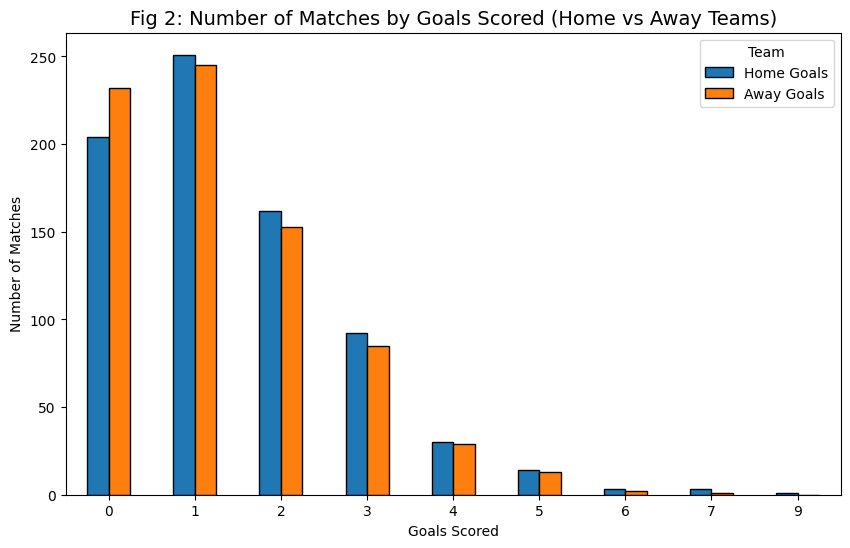

In [ ]:
home_goals_count = seasons_dataset['FTHG'].value_counts().sort_index()
away_goals_count = seasons_dataset['FTAG'].value_counts().sort_index()
goal_counts_df = pd.DataFrame({'Home Goals': home_goals_count, 'Away Goals': away_goals_count}).fillna(0)

# Goal count displayed on top of the bars
for idx, value in enumerate(goal_counts_df['Home Goals']):
    plt.text(idx - 0.2, value + 2, int(value), ha='center', color='blue', fontweight='bold')

for idx, value in enumerate(goal_counts_df['Away Goals']):
    plt.text(idx + 0.2, value + 2, int(value), ha='center', color='orange', fontweight='bold')

# Side-by-side bar plot for home and away goals plotted with titles and legend
goal_counts_df.plot(kind='bar', figsize=(10, 6), color=['#1f77b4', '#ff7f0e'], edgecolor='black')
plt.title('Fig 2: Number of Matches by Goals Scored (Home vs Away Teams)', fontsize=14)
plt.xlabel('Goals Scored', fontsize=10)
plt.ylabel('Number of Matches', fontsize=10)
plt.legend(title='Team', fontsize=10)
plt.xticks(rotation=0)
plt.show()

Generally, this plot highlights a home advantage in goal scoring, which is not extreme yet slight, but the advantage is still there. The figure also shows that low to moderate goal counts are the standard in Premier League matches.

### Goal Scoring Patterns
- **Home Advantage:** Home teams generally score slightly more often than away teams, especially in the *1–3* goal range, suggesting a modest home advantage.

- **Low Goal Counts:** Most matches see *0 to 2* goals scored by either team, indicating that high-scoring games are rare in the Premier League.

- **Rare High-Goal Matches:** Games with *4+* goals are uncommon, showing that high scores are outliers in the PL.


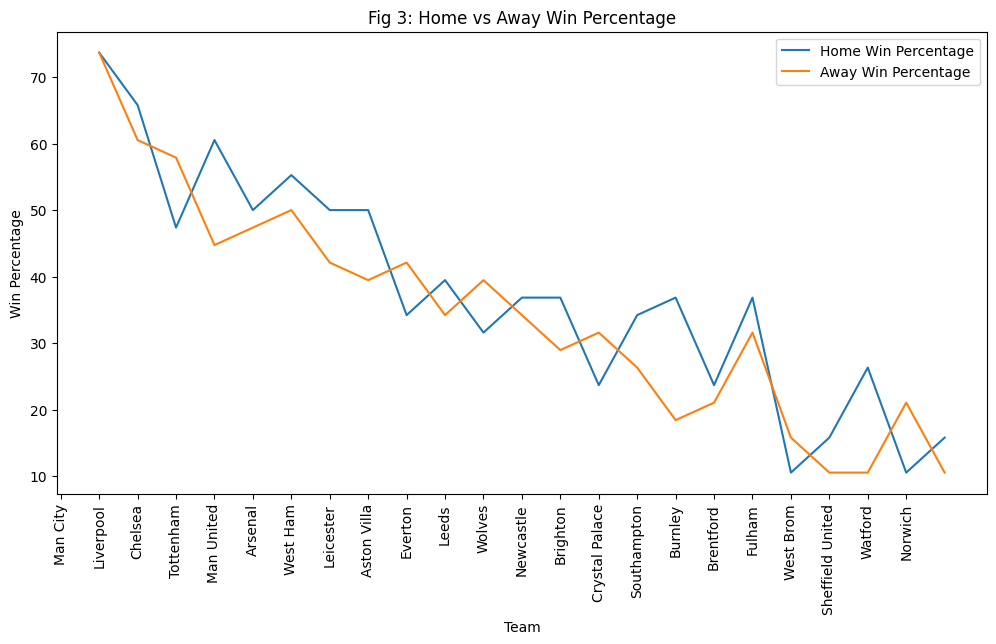

In [ ]:
standings_table[['Home Win Percentage', 'Away Win Percentage']].plot(kind='line', figsize=(12, 6))
plt.xticks(ticks=range(len(standings_table)), labels=standings_table['HomeTeam'], rotation=90)
plt.title("Fig 3: Home vs Away Win Percentage")
plt.xlabel('Team')
plt.ylabel('Win Percentage')
plt.show()


**Teams like Manchester City and Liverpool** play well at home due to the support and familiarity of their supporters with the stadium. One of the few top teams that is performing better away from home is **Chelsea**. This could be because of the owner's change and fan frustration, which has made fans less supportive over the last two years.

**Lower tier teams:** **Norwich** and **Burnley** receive slightly more support from home fans and win more games, but they still perform not well overall, perhaps as a result of factors like their lower-quality players, while **Fulham** and **Watford** win more games away from home, possibly as a result of stadium capacity issues.

Although home advantage is very common here, some teams don't always show it. About more than 15 teams have won more games at home than away, indicating the fans' obvious support. In contrast to lower-tier teams, top-tier teams typically use home games and their fans better, securing more wins at home.


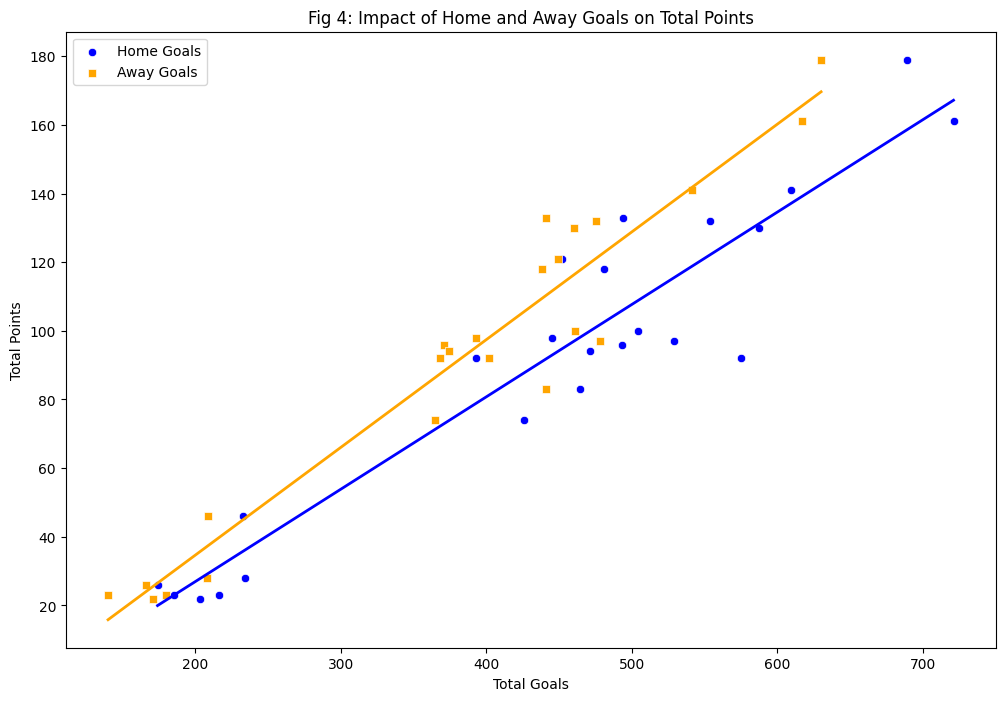

In [ ]:
# Scatter plot with refinements and confidence interval removed
plt.figure(figsize=(12, 8))

sns.scatterplot(x='Total Shots Home', y='Total Points', data=standings_table, color='blue', label='Home Goals', marker='o')
sns.scatterplot(x='Total Shots Away', y='Total Points', data=standings_table, color='orange', label='Away Goals', marker='s')
sns.regplot(x='Total Shots Home', y='Total Points', data=standings_table, scatter=False, color='blue', line_kws={"label": "Trend (Home Goals)", "lw": 2}, ci=None)
sns.regplot(x='Total Shots Away', y='Total Points', data=standings_table, scatter=False, color='orange', line_kws={"label": "Trend (Away Goals)", "lw": 2}, ci=None)

plt.title('Fig 4: Impact of Home and Away Goals on Total Points')
plt.xlabel('Total Goals')
plt.ylabel('Total Points')
plt.legend()
plt.show()


**Total Goals** and **Total Points** for both **Home** (blue) and **Away** (orange) goals are positively correlated in this plot.

- **Away Goals Are Slightly More Important:** Since away goals have a steeper line than home goals, it is likely that scoring points away is more closely related to higher total points. This is probably because strong teams are more likely to score points at home when they perform well in difficult away conditions.

- **Home Support Assistance:** Although the effect seems to be slightly less pronounced than for away goals, home goals also correlate with points, demonstrating the "12th player" fans effect.


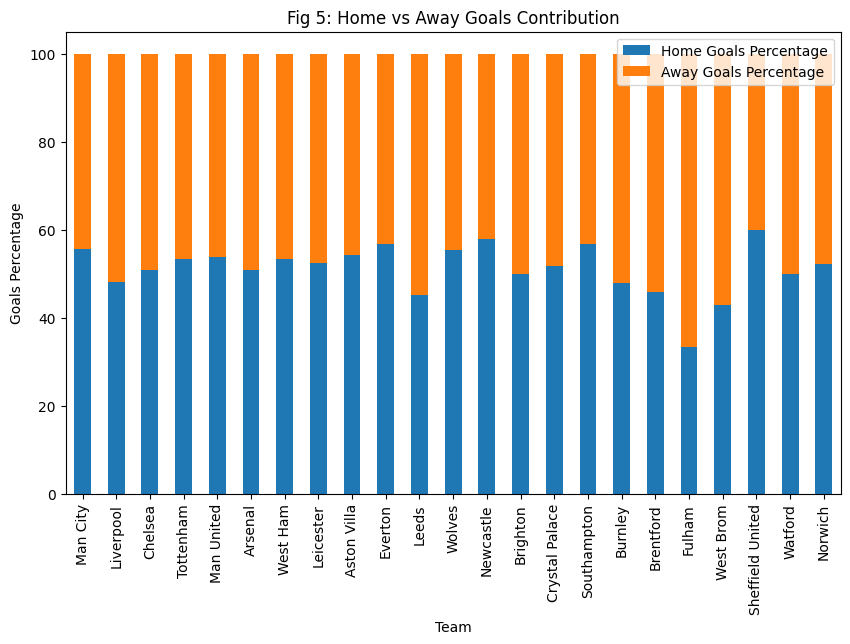

In [ ]:
standings_table[['Home Goals Percentage', 'Away Goals Percentage']].plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xticks(ticks=range(len(standings_table)), labels=standings_table['HomeTeam'], rotation=90)
plt.title('Fig 5: Home vs Away Goals Contribution')
plt.xlabel('Team')
plt.ylabel('Goals Percentage')
plt.show()

**More_Adapted Teams**

Top teams score goals consistently and strongly, achieving a nearly equal goal total at home and away.

**Home-Dependent Teams**

Lower-table teams, such as Brighton and Burnley, rely on their home crowds for goals, indicating that they require familiarity and support from fans in order to perform better. Although they aren't playing at their best, their supporters encourage them to score more goals.





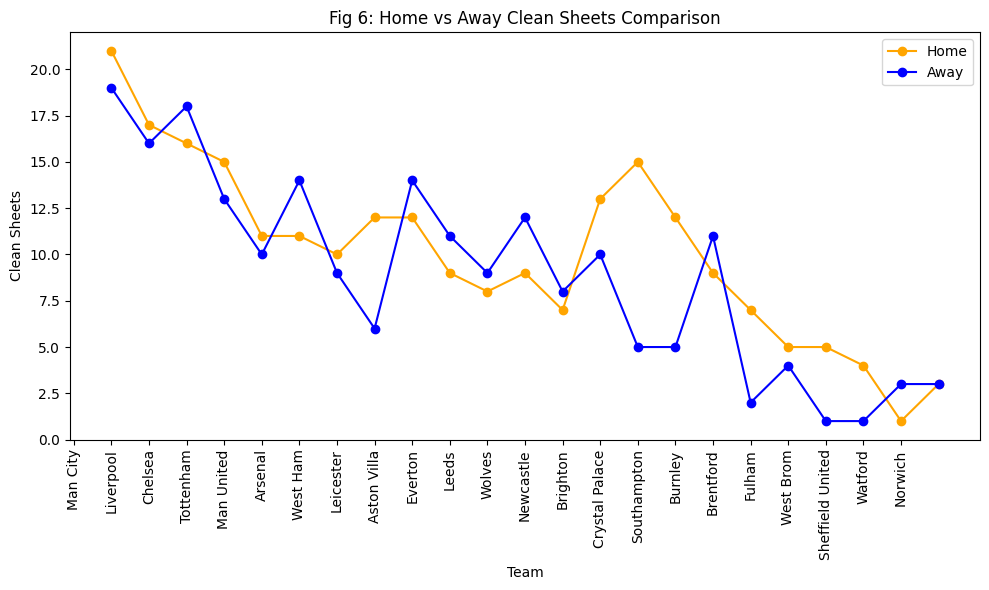

In [ ]:
# Plot for the Clean sheets distribution home and away
standings_table[['Home Clean Sheet', 'Away Clean Sheet']].plot(
    kind='line',
    figsize=(10, 6),
    marker='o',
    color=['orange', 'blue']
)
plt.xticks(ticks=range(len(standings_table)), labels=standings_table['HomeTeam'], rotation=90)
plt.title('Fig 6: Home vs Away Clean Sheets Comparison')
plt.xlabel('Team')
plt.ylabel('Clean Sheets')
plt.legend(['Home', 'Away'])
plt.tight_layout()
plt.show()



**Top-table Teams** with high home and away clean sheet totals, such as *Manchester City*, *Liverpool*, and *Chelsea*, show their consistent play and defensive power both home and away.

It seems that **mid-tier teams** like *Brighton* and *Southampton* rely heavily on home fixtures for their defensive stability because they typically record more clean sheets at their home stadiums than away stadiums.

*Norwich* and *Watford*, two of the **bottom-table teams**, have a very low number of away clean sheets, which reflects the defensive problems lower-tier teams typically face when playing away.

**Overall:**

Balanced home and away performances by top teams demonstrate adaptation regardless of the number of fans, with better performances at Home matches. However, mid- and lower-tier teams depend more on home crowds, and they frequently perform much worse away from home.


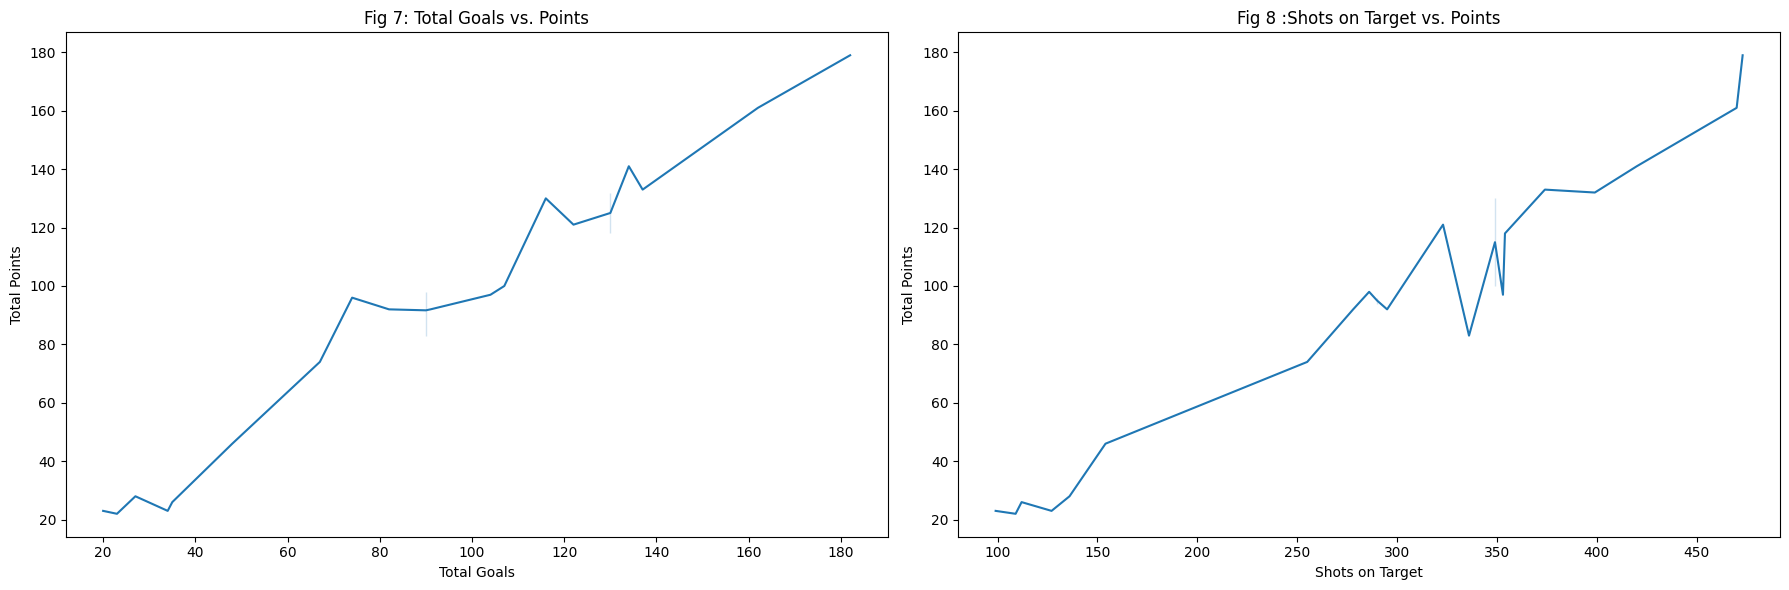

In [ ]:
# Set up the figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 1. line Plot: Total Goals vs. Total Points
sns.lineplot(x='Total Goals', y='Total Points', data=standings_table, ax=axes[0])
axes[0].set_title('Fig 7: Total Goals vs. Points')
axes[0].set_xlabel('Total Goals')
axes[0].set_ylabel('Total Points')

# 2. line Plot: Total Shots on Target vs. Total Points
sns.lineplot(x='Total Shots on Target', y='Total Points', data=standings_table, ax=axes[1])
axes[1].set_title('Fig 8 :Shots on Target vs. Points')
axes[1].set_xlabel('Shots on Target')
axes[1].set_ylabel('Total Points')

plt.tight_layout()
plt.show()


*Total Points* and *Total Goals Scored* have a **significant positive correlation**. In contrast to past trophies, which tended to concentrate more on defense and 1-0 game scores, teams with higher goals, like *Manchester City* and *Liverpool*, tend to accumulate more points, suggesting that scoring ability is a critical factor in winning trophies.

Likewise, there is a **strong positive correlation** between *Total Points* and *Shots on Target*, demonstrating the significance of generating serious goal-scoring opportunities that will ultimately result in goals. Top-tier teams more frequently score more points because they have more chances and shots on target.


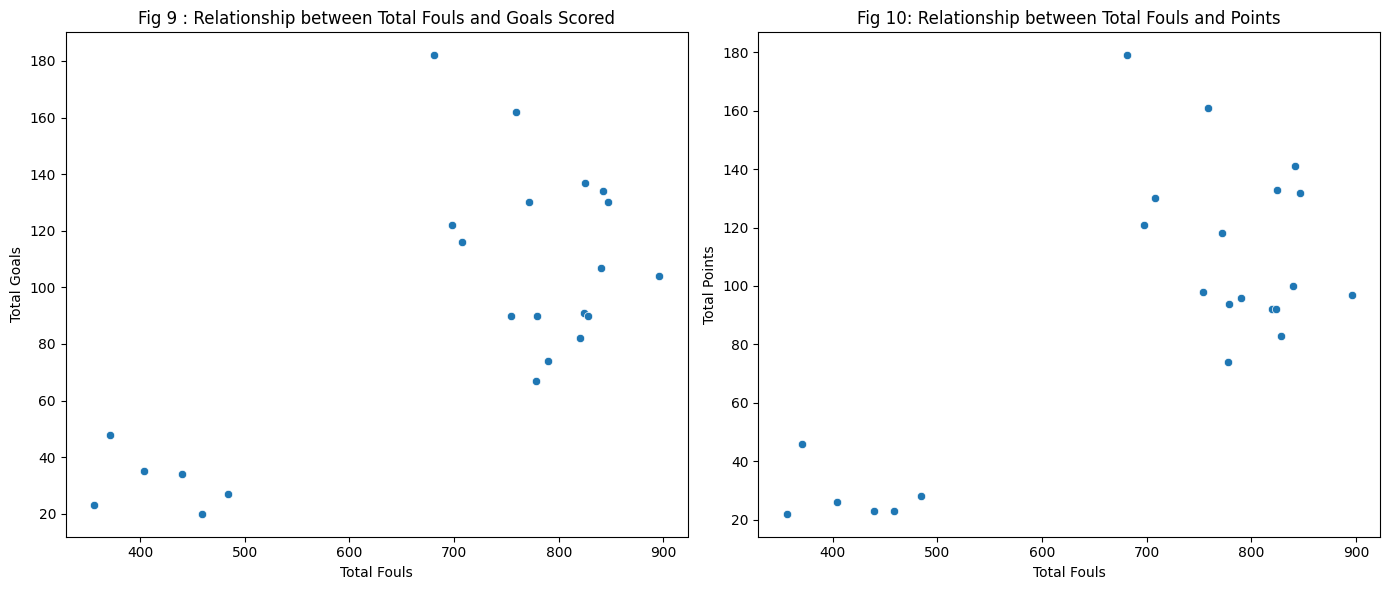

In [ ]:
# 1X2 sideplots created to show the impact of fouls
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Scatter Plot: Total Fouls vs. Total Goals
sns.scatterplot(x='Total Fouls Committed', y='Total Goals', data=standings_table, ax=axes[0])
axes[0].set_title('Fig 9 : Relationship between Total Fouls and Goals Scored')
axes[0].set_xlabel('Total Fouls')
axes[0].set_ylabel('Total Goals')

# 2. Scatter Plot: Total Fouls vs. Total Points
sns.scatterplot(x='Total Fouls Committed', y='Total Points', data=standings_table, ax=axes[1])
axes[1].set_title('Fig 10: Relationship between Total Fouls and Points')
axes[1].set_xlabel('Total Fouls')
axes[1].set_ylabel('Total Points')
plt.tight_layout()
plt.show()


The graph demonstrates that teams that play more aggressively or commit more fouls do not necessarily score more goals; instead, they may commit more fouls as a result of pressure from other teams. This is demonstrated by the plot's lack of a clear trend and the weak correlation between *Fouls Committed* and *Goals Scored*.

Additionally, since the trendline is not visible in this plot, *Fouls* do not appear to have a direct impact on *Total Points*.


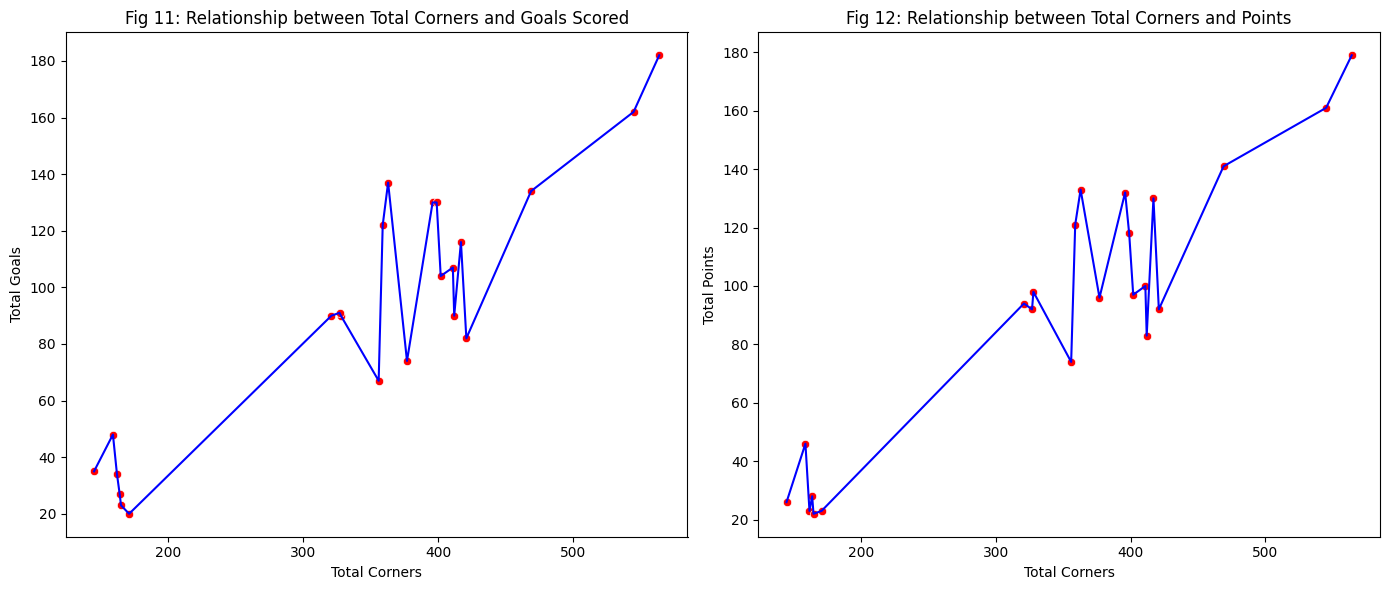

In [ ]:
# 1X2 side-by-side plots created to show the impact of corners
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter Plot: Total Corners and Total Goals
sns.scatterplot(x='Total Corners', y='Total Goals', data=standings_table, ax=axes[0], color='red')
sns.lineplot(x='Total Corners', y='Total Goals', data=standings_table, ax=axes[0], color='blue')
axes[0].set_title('Fig 11: Relationship between Total Corners and Goals Scored')
axes[0].set_xlabel('Total Corners')
axes[0].set_ylabel('Total Goals')

# Scatter Plot: Total Corners and Total Points
sns.scatterplot(x='Total Corners', y='Total Points', data=standings_table, ax=axes[1], color='red')
sns.lineplot(x='Total Corners', y='Total Points', data=standings_table, ax=axes[1], color='blue')
axes[1].set_title('Fig 12: Relationship between Total Corners and Points')
axes[1].set_xlabel('Total Corners')
axes[1].set_ylabel('Total Points')

plt.tight_layout()
plt.show()


**Corners Relationship with Goals and Points:**

The plots indicate a moderate positive relationship between *Goals* and *Corners*, suggesting that set pieces help score more goals but that the relationship is not as strong as that of *Shots on Target*. This is justifiable since the turnover rate of a corner is less than that of a shot on target. There is also a positive correlation between *Corners* and *Points*, meaning that corners increase the opponent's threat level, goal-scoring opportunities, and wins, which results in more points.

There are some fluctuations in the line, particularly for mid-table teams that receive a good number of corners but might not convert it to actual goals, which is probably due to differences in set-piece training between mid-table teams.


In [ ]:
# 1X2 Sideplot to comapre attack and defence tactics
fig = make_subplots(rows=1, cols=2, subplot_titles=('Total Goals vs Total Points', 'Total Clean Sheets vs Total Points'))

#Total Goals vs Total Points
fig.add_trace(
    go.Scatter(x=standings_table['Total Goals'], y=standings_table['Total Points'],
               mode='markers+lines', marker=dict(color='blue', size=8), name="Total Goals"),
    row=1, col=1
)
# Total Clean Sheets vs Total Points
fig.add_trace(
    go.Scatter(x=standings_table['Total Clean Sheets'], y=standings_table['Total Points'],
               mode='markers+lines', marker=dict(color='green', size=8), name="Total Clean Sheets"),
    row=1, col=2
)

fig.update_layout(
    title_text='Fig 13: Comparison of Attack (Goals) vs Defense (Clean Sheets) and Their Relationship with Points',
    xaxis_title="Total Goals",
    yaxis_title="Total Points",
    xaxis2_title="Total Clean Sheets",
    yaxis2_title="Total Points",
    showlegend=False,
)
fig.show()


The plot of *Total Goals* versus *Total Points* displays a clear, upward trend that highlights the strong relationship between **attacks** and **points**. The higher the goals, the more points gained, emphasizing the importance of offensive strength in achieving higher points.

Although **Clean Sheets** are a major factor in determining the winner, the trend between *Total Clean Sheets* and *Total Points* is also positive but more staggered, especially around the **Mid-Table teams**. This indicates that clean sheets don’t have as much of an impact on points as goal-scoring.


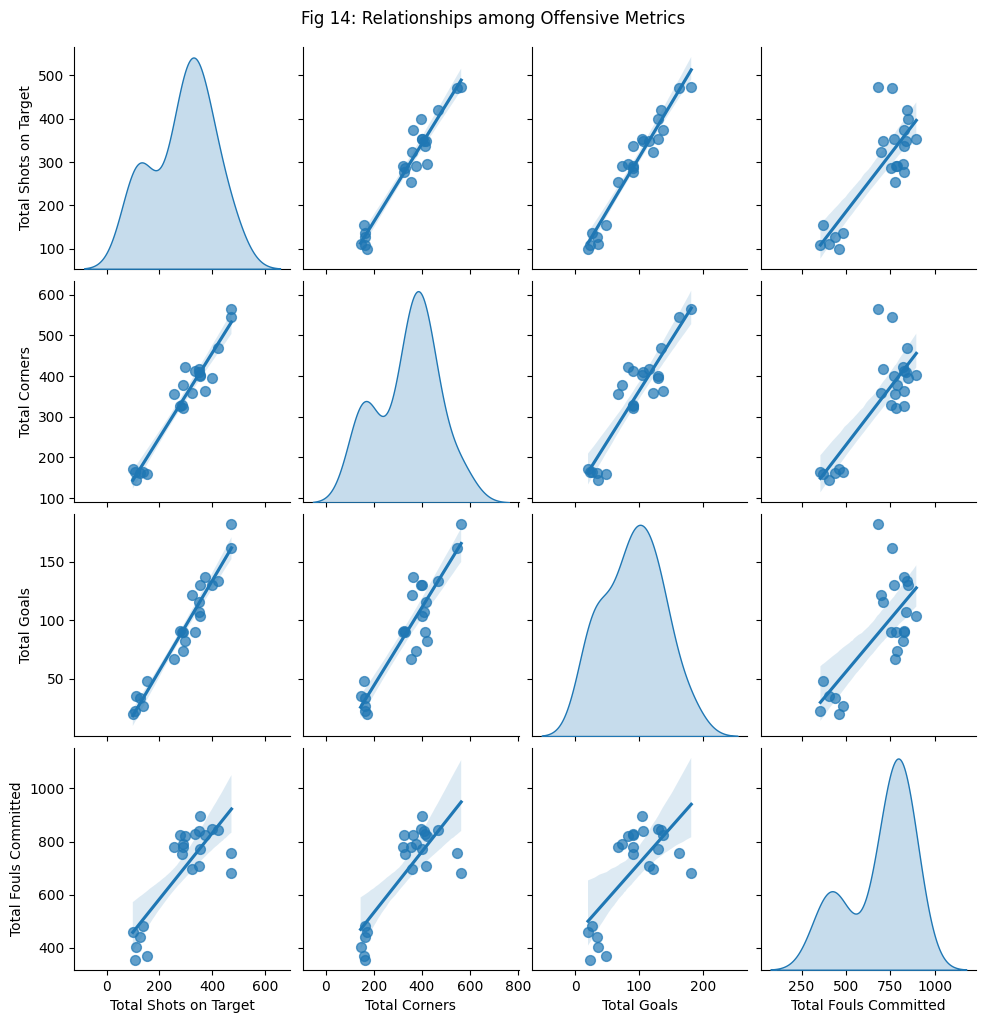

In [ ]:
offensive_metrics = standings_table[['Total Shots on Target', 'Total Corners', 'Total Goals', 'Total Fouls Committed']]
sns.pairplot(offensive_metrics, kind='reg', diag_kind='kde', plot_kws={'scatter_kws': {'s': 50, 'alpha': 0.7}})
plt.suptitle('Fig 14: Relationships among Offensive Metrics', y=1.02)
plt.show()



The pair plot supports the idea that offensive strength is correlated with scoring more points by validating the strong correlations across important offensive metrics (*shots on target*, *goals*, and *corners*).

Conversely, defensive metrics such as *fouls committed* have lower correlations with goals or points, indicating that offensive strategies have a greater impact on winning than aggressive or strictly defensive tactics.

**Overall Analysis:**

Top teams frequently continue to play well both at home and away, demonstrating their adaptability to various conditions. However, in order to gain more points, mid-tier teams usually rely more on home games.
Upon analyzing the plots above ,an offensive style of play, focusing more attacking and more chance creation, shooting on target, and scoring, is necessary for moving up the league table, according to an analysis of these performance metrics. No matter the opponent, getting all the points, winning at home should be a top priority for mid-tier teams, especially those hoping to qualify for the Champions League. Aiming for a win or draw away from home is advantageous because away games can add important points to their title or standings race. Although reducing the number of goals conceded is extremely crucial, offensive play typically generates more success than purely defensive tactics which tended to be more of an outdated game-plan of previous managers like Fabio Capello and Jose Muorinho.


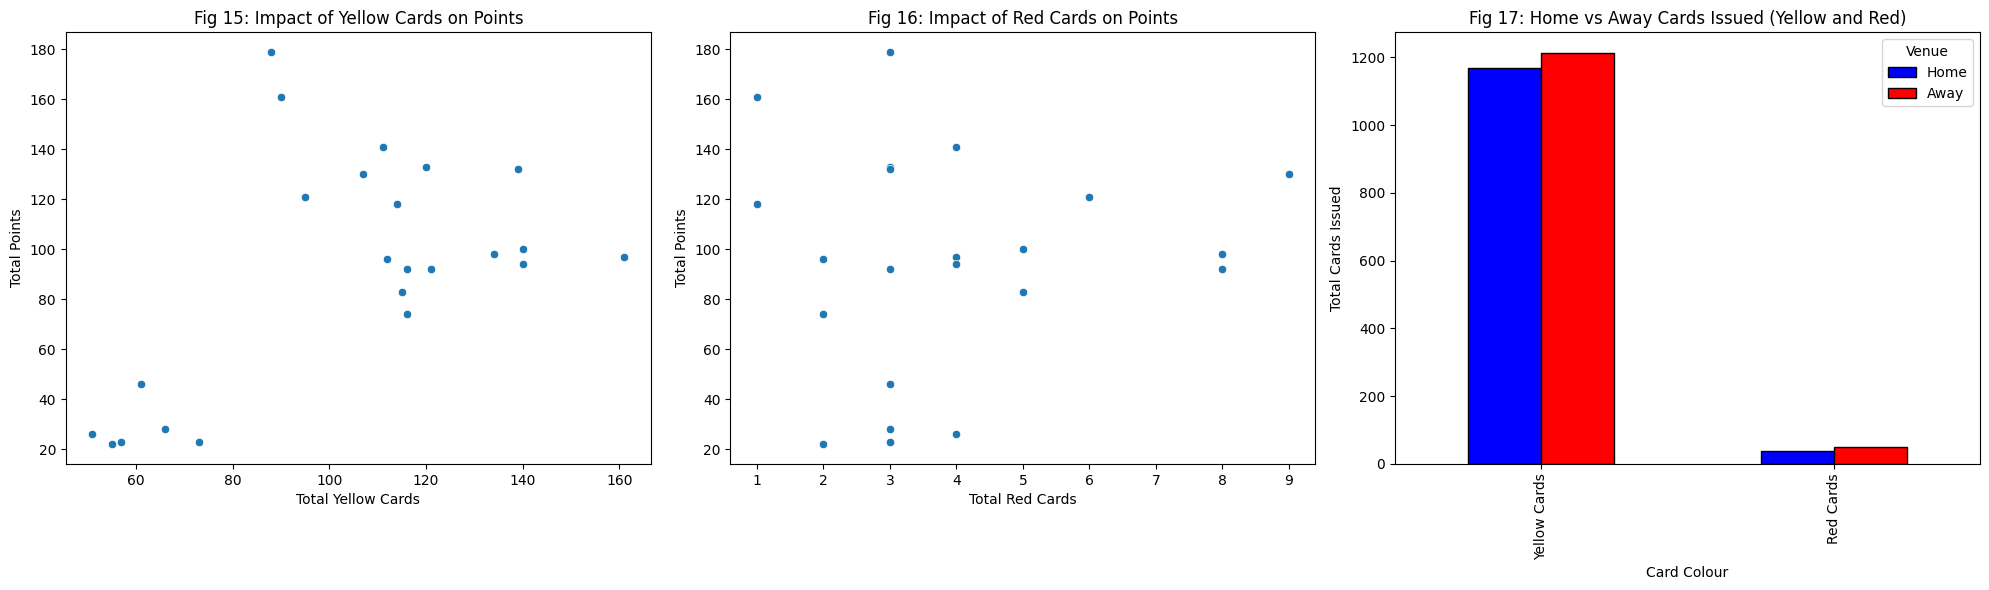

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Yellow Cards vs. Total Points in a scatter plot
sns.scatterplot(x='Total Yellow Cards', y='Total Points', data=standings_table, ax=axes[0])
axes[0].set_title('Fig 15: Impact of Yellow Cards on Points')
axes[0].set_xlabel('Total Yellow Cards')
axes[0].set_ylabel('Total Points')

# Red Cards vs. Total Points in a scatter plot
sns.scatterplot(x='Total Red Cards', y='Total Points', data=standings_table, ax=axes[1])
axes[1].set_title('Fig 16: Impact of Red Cards on Points')
axes[1].set_xlabel('Total Red Cards')
axes[1].set_ylabel('Total Points')

# Home vs Away Cards Issued in a double bar chart with yellow and red cards
home_away_cards = standings_table[['Yellow Cards Home', 'Yellow Cards Away', 'Red Cards Home', 'Red Cards Away']].sum()
card_data = pd.DataFrame({
    'Home': [home_away_cards['Yellow Cards Home'], home_away_cards['Red Cards Home']],
    'Away': [home_away_cards['Yellow Cards Away'], home_away_cards['Red Cards Away']]
}, index=['Yellow Cards', 'Red Cards'])

card_data.plot(kind='bar', color=['blue', 'red'], edgecolor='black', ax=axes[2])
axes[2].set_title('Fig 17: Home vs Away Cards Issued (Yellow and Red)')
axes[2].set_xlabel('Card Colour')
axes[2].set_ylabel('Total Cards Issued')
axes[2].legend(title='Venue')

plt.tight_layout()
plt.show()


Figures 15 and 16 show that there is a weak correlation between the *Total Points* and the number of *Yellow* and *Red Cards*, indicating that yellow cards have little to no impact on points gathered by a team.

However, teams with fewer red cards generally achieve more points relatively. It is harder to track this metric since red cards are few throughout the season, so perhaps accumulated data over 10 seasons would provide more insight.

In Fig 17, it is evident that teams usually receive more yellow cards during *Away* games than *Home* games. This could be due to increased defensive aggression in away games, or possibly because referees favor home teams, influenced by the pressure from home fans.


<ipython-input-124-71dc513d3c5f>:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-124-71dc513d3c5f>:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




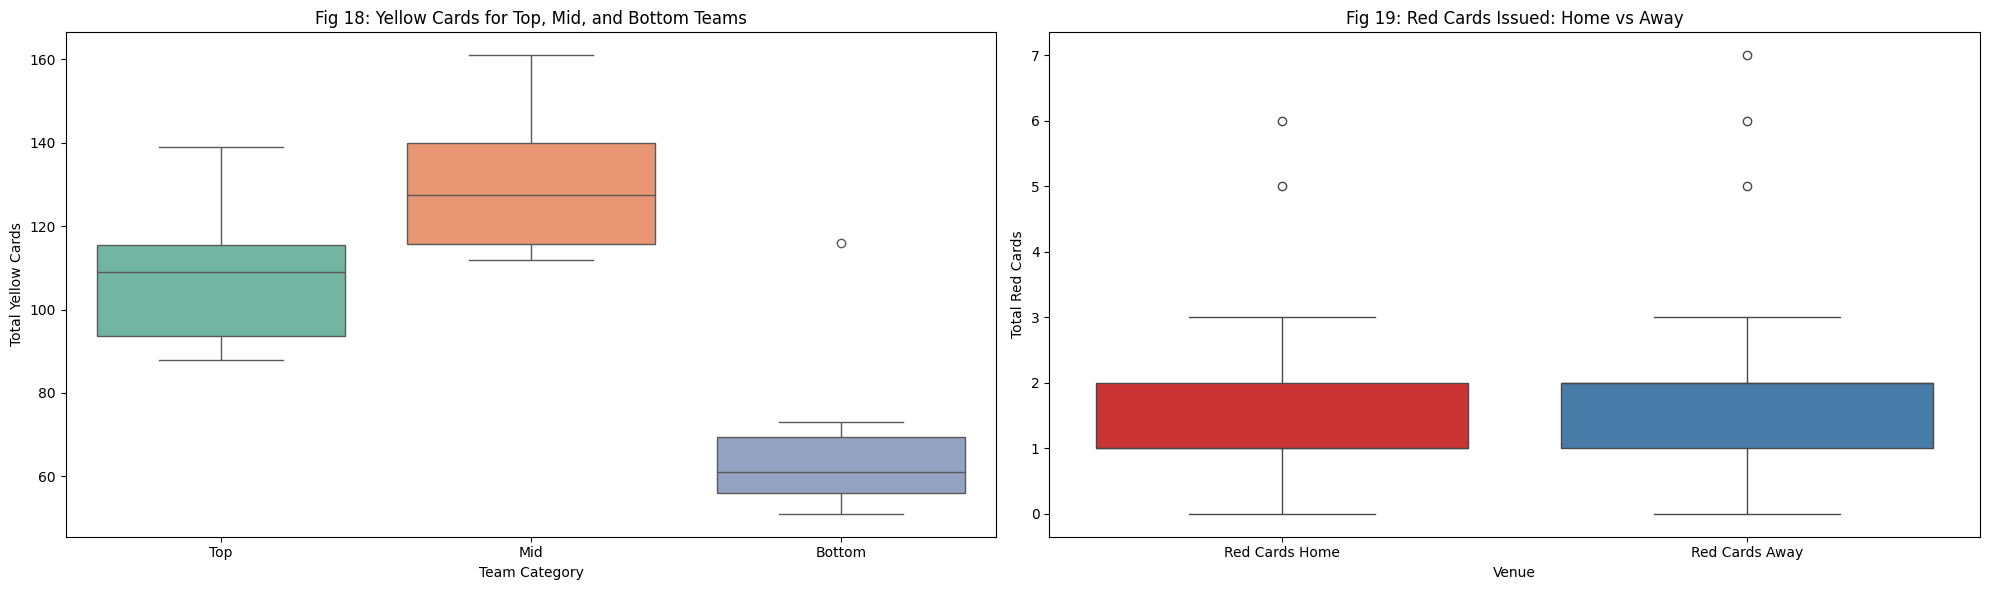

In [ ]:
# Set up the figure for a 1x2 grid layout
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Function to categorize teams based on their team rank
def categorize_team(rank):
    if rank <= 8:
        return 'Top'
    elif 9 <= rank <= 16:
        return 'Mid'
    else:
        return 'Bottom'

standings_table['Team Category'] = standings_table['Rank'].apply(categorize_team)

# Yellow Cards by Team Category in
sns.boxplot(x='Team Category', y='Total Yellow Cards', data=standings_table, palette='Set2', ax=axes[0])
axes[0].set_title('Fig 18: Yellow Cards for Top, Mid, and Bottom Teams')
axes[0].set_xlabel('Team Category')
axes[0].set_ylabel('Total Yellow Cards')

# Plot 2: Box Plot - Red Cards Issued Home vs Away
red_cards_data = standings_table[['Red Cards Home', 'Red Cards Away']].melt(var_name='Location', value_name='Red Cards')
sns.boxplot(x='Location', y='Red Cards', data=red_cards_data, palette='Set1', ax=axes[1])
axes[1].set_title('Fig 19: Red Cards Issued: Home vs Away')
axes[1].set_xlabel('Venue')
axes[1].set_ylabel('Total Red Cards')

plt.tight_layout()
plt.show()


To determine which teams receive more cards, I created a function to split the teams into three groups: **top**, **middle**, and **bottom**.

**Yellow Cards**:  
  Surprisingly, yellow cards are the lowest among the **bottom tier** category. On the other hand, **mid-table teams** typically receive the most yellow cards, as seen in **Fig. 18**. This could be because they play more aggressively or physically in an attempt to move up the rankings.

 **Red Cards**:  
  **Fig 19** displays that there is a kind of even distribution of red cards between **home** and **away** games, suggesting that red card decisions may remain consistent regardless of the location.


<ipython-input-125-5f98283a5710>:18: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



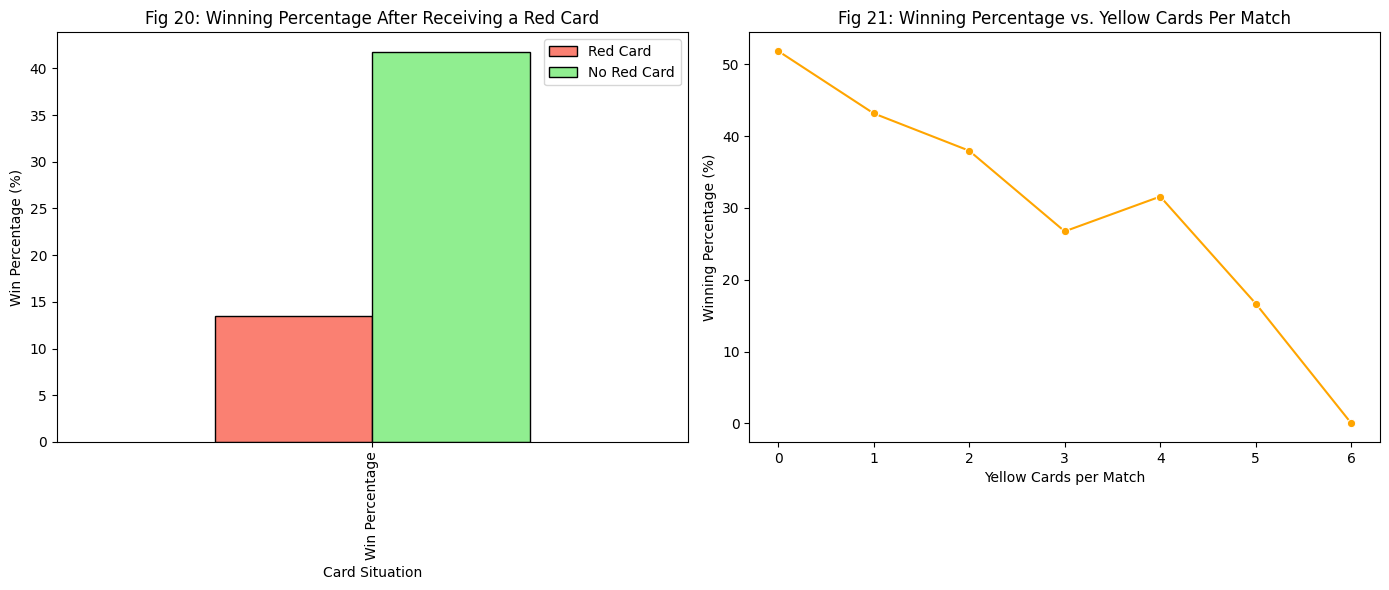

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# calculation process before plotting
red_card_wins = seasons_dataset[seasons_dataset['HR'] > 0].groupby('FTR').size().get('H', 0) / len(seasons_dataset[seasons_dataset['HR'] > 0]) * 100
no_red_card_wins = seasons_dataset[seasons_dataset['HR'] == 0].groupby('FTR').size().get('H', 0) / len(seasons_dataset[seasons_dataset['HR'] == 0]) * 100
win_data = pd.DataFrame({
    'Red Card': [red_card_wins],
    'No Red Card': [no_red_card_wins]
}, index=['Win Percentage'])

# Winning Percentage After Receiving Red Cards
win_data.plot(kind='bar', color=['salmon', 'lightgreen'], edgecolor='black', ax=axes[0])
axes[0].set_title('Fig 20: Winning Percentage After Receiving a Red Card')
axes[0].set_xlabel('Card Situation')
axes[0].set_ylabel('Win Percentage (%)')

# Yellow Cards per Match and Winning Percentage
yellow_card_wins = seasons_dataset.groupby('HY').apply(lambda x: (x['FTR'] == 'H').mean() * 100)
sns.lineplot(x=yellow_card_wins.index, y=yellow_card_wins.values, marker='o', color='orange', ax=axes[1])
axes[1].set_title('Fig 21: Winning Percentage vs. Yellow Cards Per Match')
axes[1].set_xlabel('Yellow Cards per Match')
axes[1].set_ylabel('Winning Percentage (%)')

plt.tight_layout()
plt.show()


**Fig 20** shows a significant difference in win percentage for teams with and without red cards.  Due to the disadvantage of playing with fewer players, which forces teams to change their gameplay styles and makes them more likely to concede goals without creating chances and following their pre game attacking tactics. Consequently, teams that avoid red cards have a significantly higher winning percentage, indicating that red cards have a negative impact on a team's winning probability.

**Fig 21** suggests that a team with more yellow cards is more aggressive, which is correlated with a lower chance of winning.Teams with zero yellow cards per match tend to have higher winning percentage than teams than for example 2-3 and even 6 yellow cards. This could be due to players who have already received a yellow card may be more cautious to avoid receiving a second yellow card and being sent out.


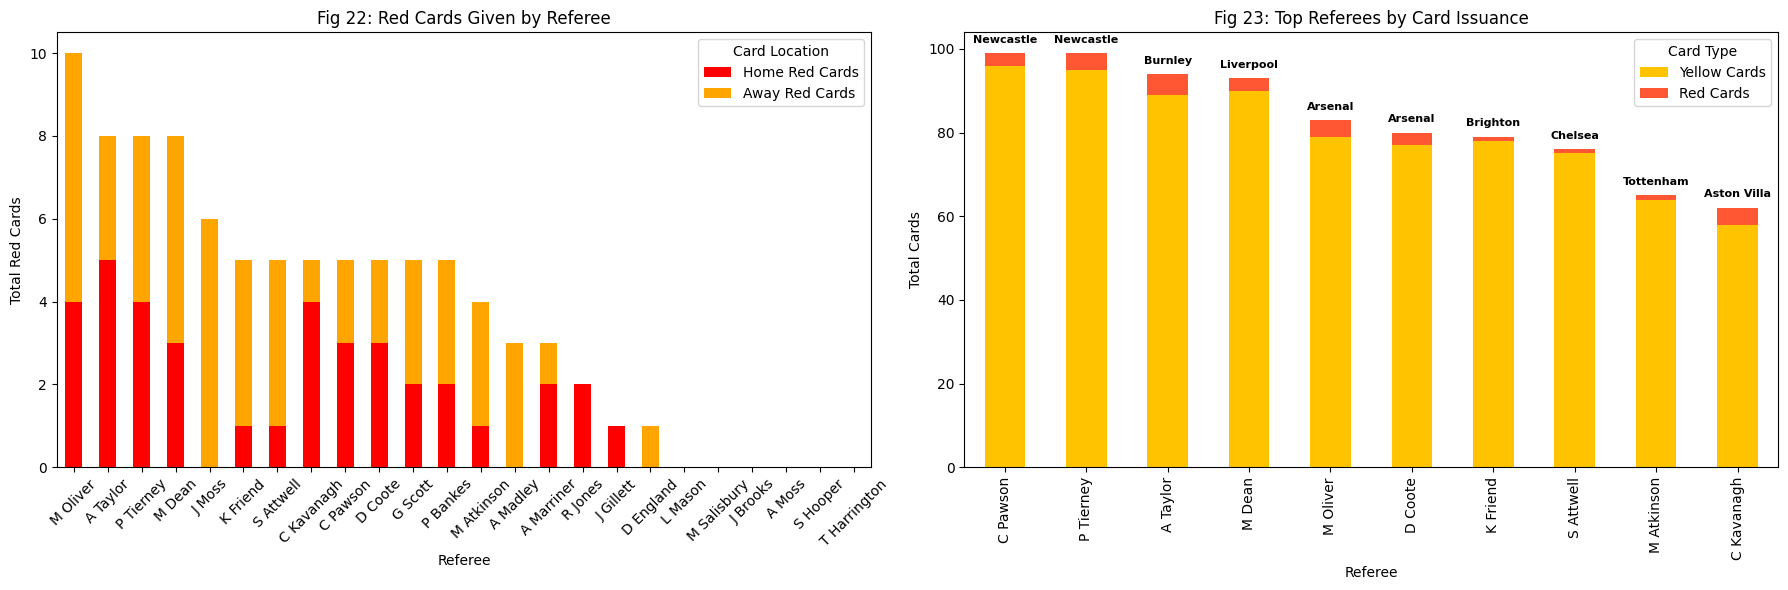

In [ ]:
# Total red cards and yellow cards by each referee calcuated and sorted
referee_cards = seasons_dataset.groupby('Referee')[['HR', 'AR', 'HY']].sum()
referee_cards['Total Red Cards'] = referee_cards['HR'] + referee_cards['AR']
referee_cards['Total Cards'] = referee_cards['HY'] + referee_cards['HR']
referee_cards = referee_cards.sort_values(by='Total Red Cards', ascending=False)
top_referees = referee_cards.sort_values(by='Total Cards', ascending=False).head(10)

# Find the most frequent team for each top referee
frequent_team_by_referee = (
    seasons_dataset.groupby(['Referee', 'HomeTeam']).size()
    .reset_index(name='Match Count')
    .sort_values(['Referee', 'Match Count'], ascending=[True, False])
    .drop_duplicates('Referee')
    .set_index('Referee')
)
top_referees = top_referees.join(frequent_team_by_referee[['HomeTeam', 'Match Count']])

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Red Cards Given by Referee (Home vs Away Teams)
referee_cards[['HR', 'AR']].plot(kind='bar', stacked=True, color=['red', 'orange'], ax=axes[0])
axes[0].set_title('Fig 22: Red Cards Given by Referee')
axes[0].set_xlabel('Referee')
axes[0].set_ylabel('Total Red Cards')
axes[0].legend(['Home Red Cards', 'Away Red Cards'], title='Card Location')
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Top Referees by Card Issuance (Yellow and Red)
top_referees[['HY', 'HR']].plot(kind='bar', stacked=True, color=['#FFC300', '#FF5733'], ax=axes[1])
axes[1].set_title('Fig 23: Top Referees by Card Issuance')
axes[1].set_xlabel('Referee')
axes[1].set_ylabel('Total Cards')
axes[1].legend(['Yellow Cards', 'Red Cards'], title='Card Type')

# add the names of teams to check bias
for i, ref in enumerate(top_referees.index):
    team = top_referees.loc[ref, 'HomeTeam']
    axes[1].text(i, top_referees.loc[ref, 'Total Cards'] + 2.5, f'{team}', ha='center', fontsize=8, color='black', weight='bold')

plt.tight_layout()
plt.show()


Referees like *M. Oliver* and *A. Taylor* are in charge of issuing the most red cards, as shown in **Fig. 22** . There appears to be a slight home-field advantage effect as *M.Dean* and *M. Oliver* for example , have a slight tendency to penalise away teams more.

Referees like *C. Pawson*, *P. Tierney*, and *A. Taylor* are also among the most frequent issuers of both yellow and red cards, as shown in **Fig. 22**. In particular, teams like *Newcastle*, *Burnley*, *Arsenal*, and *Liverpool* are the teams that these strict referees officiate the most, whereas *Manchester City*, which is frequently mentioned as a team that referees' decisions favor, is not one of the teams that these referees officiate the most.

Since major title contenders like *Liverpool*, *Chelsea*, and *Arsenal* frequently face these stricter referees, the difference raises the question of possible biases or repeated interactions with particular teams in favor of other teams. This trend might imply that some teams have an implicit edge over others, which could affect the league final results.


<ipython-input-127-392c0bf4dd1e>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




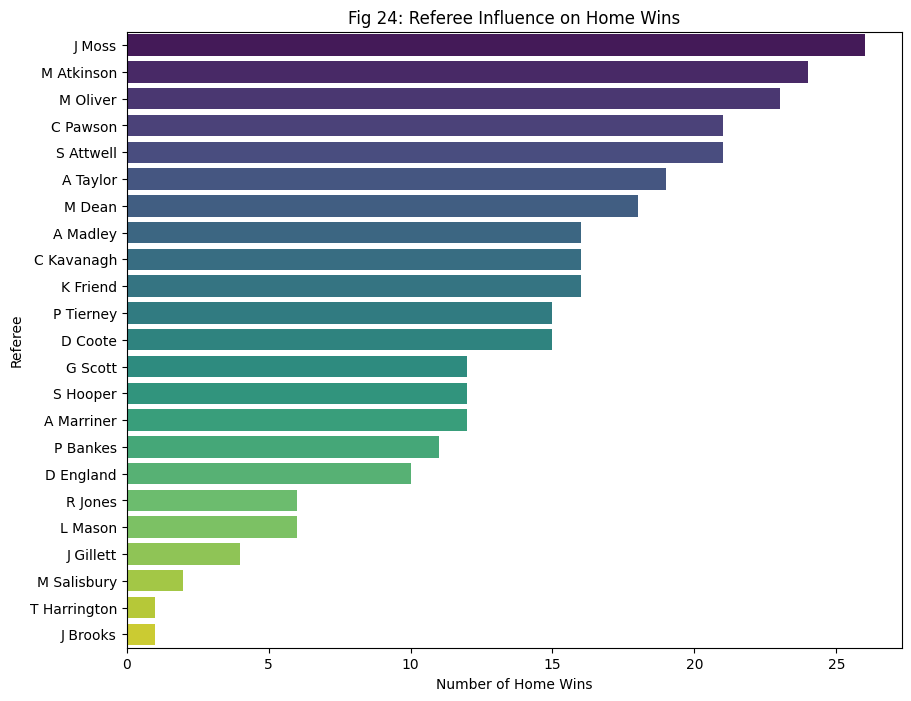

In [ ]:
# Referee Influence on Home Wins
referee_wins = seasons_dataset[seasons_dataset['FTR'] == 'H']['Referee'].value_counts()

plt.figure(figsize=(10, 8))
sns.barplot(y=referee_wins.index, x=referee_wins.values, palette='viridis')
plt.title('Fig 24: Referee Influence on Home Wins')
plt.xlabel('Number of Home Wins')
plt.ylabel('Referee')
plt.show()


**Fig 24** shows the impact of referees on Premier League home victories. The plot displays that referees like *J. Moss*, *M. Atkinson*, and *M. Oliver* are associated with more home victories, which may suggest that they have a trend to make decisions in favor of home teams.

This pattern raises the possibility that some referees may change game results in favor of home teams, if they are pressured by the fans, for example, which could affect the final result of the league.



**Overall:**

Consistent success in the league requires disciplined play which involves less fouls and cards issued as well as adaptability in dealing with different referees' styles. Teams that avoid receiving yellow and red cards on a regular basis maintain their strength in the league and reduce the possibility of facing setbacks in matches which would cause them to lose the three points.

Referee assignments may also be accused of biasness with some referees regularly officiating more games for some teams than others. This pattern highlights the indirect role referees may play in determining league standings, as it could subtly affect match outcomes and even the title race.


### Team Expenditures
In order to determine the relationship between spending and the team's success or failure in the Premier League, I scraped the TransferMarket website to obtain the income and spending and other financial metrics that reflect player transfers and test its effect on league standings.

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def scrape_error_handle(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36',
        'Accept-Language': 'en-US,en;q=0.9',
        'Referer': 'https://www.google.com/'
    }
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        return soup
    except requests.RequestException as e:
        print(f"Error fetching {url}: {e}")
        return None

def team_expenditures(url):
    soup = scrape_error_handle(url)
    if not soup:
        print("Failed to fetch data from Transfermarkt.")
        return pd.DataFrame()

    rows = soup.find_all('tr')
    scraped_team_dict = {}

    for row in rows:
        # Check for the presence of the required elements in the row to avoid index errors
        team_column = row.find('td', class_='hauptlink no-border-links')
        expenditure_column = row.find('td', class_='rechts hauptlink redtext')
        income_column = row.find('td', class_='rechts hauptlink greentext')

        balance_columns = row.find_all('td', class_='rechts')
        zentriert_columns = row.find_all('td', class_='zentriert')

        if team_column and expenditure_column and income_column and len(balance_columns) > 0 and len(zentriert_columns) > 3:
            team_name = team_column.find('a').text.strip()
            expenditure_text = expenditure_column.text.strip()
            income_text = income_column.text.strip()
            balance_text = balance_columns[-1].text.strip()  # Assumes balance is the last `rechts` column
            arrivals = zentriert_columns[2].text.strip()  # Arrivals are at index 2
            departures = zentriert_columns[3].text.strip()  # Departures are at index 3

            # Add all columns to the dictionary
            scraped_team_dict[team_name] = {
                'Expenditure': expenditure_text,
                'Income': income_text,
                'Balance': balance_text,
                'Arrivals': arrivals,
                'Departures': departures
            }

    # Create DataFrame from the dictionary
    df_league_teams = pd.DataFrame.from_dict(scraped_team_dict, orient='index').reset_index()
    df_league_teams.columns = ['Hometeam', 'Expenditure', 'Income', 'Balance', 'Arrivals', 'Departures']

    # Convert monetary values to millions for consistency
    def unit_convertor(value):
        value = value.replace('€', '').strip()
        if value.endswith('bn'):
            return float(value.replace('bn', '').replace(',', '.')) * 1000  # Convert billion to million
        elif value.endswith('m'):
            return float(value.replace('m', '').replace(',', '.'))
        elif value.endswith('k'):
            return float(value.replace('k', '').replace(',', '.')) / 1000  # Convert thousand to million
        return 0

    # Apply the conversion to financial columns
    for column in ['Expenditure', 'Income', 'Balance']:
        df_league_teams[column] = df_league_teams[column].apply(unit_convertor)

    # Sort and get the top 23 teams by expenditure
    df_top_10 = df_league_teams.sort_values(by='Expenditure', ascending=False).head(23)
    return df_top_10

# Test the function with the Transfermarkt URL
url_transfermarkt = "https://www.transfermarkt.us/premier-league/einnahmenausgaben/wettbewerb/GB1/plus/0?ids=a&sa=&saison_id=2020&saison_id_bis=2021&nat=&pos=&altersklasse=&w_s=&leihe=&intern=0"
expenditure_df = team_expenditures(url_transfermarkt)
print(expenditure_df)


                   Hometeam  Expenditure  Income  Balance Arrivals Departures
0                Chelsea FC       365.20  211.84  -153.37       52         49
1           Manchester City       312.30  157.80  -154.50       49         51
2                Arsenal FC       253.40   50.55  -202.85       29         36
3               Aston Villa       231.15  129.77  -101.38       34         33
4         Manchester United       225.95   50.60  -175.35       33         31
5         Tottenham Hotspur       206.40   47.92  -158.48       29         30
6              Leeds United       187.10    0.00  -187.10       29         31
7              Liverpool FC       176.80   48.85  -127.95       31         25
8          Newcastle United       169.25    0.78  -168.47       22         25
9           West Ham United       129.20   49.65   -79.56       26         25
10           Leicester City       127.00   57.77   -69.23       30         29
11  Wolverhampton Wanderers       125.19  111.00   -14.19       

In [ ]:
# Renaming for standardization
expenditure_df = expenditure_df.rename(columns={'Hometeam': 'Team'})
standings_table['Team'] = standings_table['HomeTeam'].str.strip().str.lower()
expenditure_df['Team'] = expenditure_df['Team'].str.strip().str.lower()

# Mapping needed to change the team names since they were not the same
team_name_mapping = {'chelsea': 'chelsea fc',
    'man city': 'manchester city',
    'arsenal': 'arsenal fc',
    'aston villa': 'aston villa',
    'man united': 'manchester united',
    'tottenham': 'tottenham hotspur',
    'leeds': 'leeds united',
    'liverpool': 'liverpool fc',
    'newcastle': 'newcastle united',
    'west ham': 'west ham united',
    'leicester': 'leicester city',
    'wolves': 'wolverhampton wanderers',
    'brighton': 'brighton & hove albion',
    'everton': 'everton fc',
    'crystal palace': 'crystal palace',
    'southampton': 'southampton fc',
    'norwich': 'norwich city',
    'sheffield': 'sheffield united',
    'fulham': 'fulham fc',
    'west brom': 'west bromwich albion',
    'burnley': 'burnley fc',
    'brentford': 'brentford fc',
    'watford': 'watford fc'
}

standings_table['Team'] = standings_table['Team'].replace(team_name_mapping)
expenditures_with_performance = expenditure_df.merge(standings_table, on='Team', how='left')

# Sort by 'Total Points' in descending order
expenditures_with_performance = expenditures_with_performance.sort_values(by='Total Points', ascending=False)
expenditures_with_performance.reset_index(drop=True, inplace=True)
expenditures_with_performance.index += 1
expenditures_with_performance.head(23)


,Team,Expenditure,Income,Balance,Arrivals,Departures,HomeTeam,Total Points,Win Percentage,Home Win Percentage,...,Fouls Committed Home,Fouls Committed Away,Total Corners,Corners Home,Corners Away,Home Clean Sheet,Away Clean Sheet,Total Clean Sheets,Rank,Team Category
1,manchester city,312.30,157.80,-154.50,49,51,Man City,179,73.68,73.68,...,341,340,564,311,253,21,19,40,1,Top
2,liverpool fc,176.80,48.85,-127.95,31,25,Liverpool,161,63.16,65.79,...,376,383,545,292,253,17,16,33,2,Top
3,chelsea fc,365.20,211.84,-153.37,52,49,Chelsea,141,52.63,47.37,...,434,408,469,254,215,16,18,34,3,Top
4,tottenham hotspur,206.40,47.92,-158.48,29,30,Tottenham,133,52.63,60.53,...,447,378,363,192,171,15,13,28,4,Top
5,manchester united,225.95,50.60,-175.35,33,31,Man United,132,48.68,50.00,...,388,459,396,208,188,11,10,21,5,Top
6,arsenal fc,253.40,50.55,-202.85,29,36,Arsenal,130,52.63,55.26,...,369,339,417,243,174,11,14,25,6,Top
7,west ham united,129.20,49.65,-79.56,26,25,West Ham,121,46.05,50.00,...,359,339,359,193,166,10,9,19,7,Top
8,leicester city,127.00,57.77,-69.23,30,29,Leicester,118,44.74,50.00,...,388,384,399,205,194,12,6,18,8,Top
9,aston villa,231.15,129.77,-101.38,34,33,Aston Villa,100,38.16,34.21,...,422,418,411,210,201,12,14,26,9,Mid
10,everton fc,113.87,50.43,-63.45,34,35,Everton,98,36.84,39.47,...,361,393,328,191,137,9,11,20,10,Mid


In [ ]:
fig = px.bar(
    expenditures_with_performance,
    x=["Expenditure", "Income", "Balance"],
    y="Team",
    orientation="h",
    title="Fig 25: Expenditure, Income, and Balance by Team",
    barmode="group",
    labels={"value": "Amount (in million €)", "variable": "Financial Metric"}
)
fig.show()


This figure shows an overview of the financial preformance of some teams.Most teams have negative balances showing that the expenditure> income showing the amount of money spent each year by the premier league teams to compete. For instance,Manchester City, Chelsea FC, and Manchester United have high expenditures and also large negative balances, indicating they are spending significantly more than they are earning. It is predicted that these high-expenditure teams often rank higher in terms of performance metrics, suggesting that higher spending correlates with success, so lets test it.

In [ ]:
# Select relevant columns for correlation
relevant_metrics = expenditures_with_performance[[
    "Expenditure", "Income", "Balance", "Total Points",
    "Total Goals","Total Shots on Target" , 'Arrivals' , 'Departures',"Total Corners", 'Total Fouls Committed',
    'Yellow Cards Home', 'Yellow Cards Away', 'Red Cards Home', 'Red Cards Away',
]]
corr_matrix = relevant_metrics.corr().round(2)


# Plot the heatmap
fig = ff.create_annotated_heatmap(
    z=corr_matrix.values,
    x=list(corr_matrix.columns),
    y=list(corr_matrix.index),
    showscale=True
)
fig.update_layout(title="Fig 26: Correlation Matrix of Financial and Performance Metrics")
fig.show()


**Analyzing the correlation matrix:**

Expenditure shows a strong positive correlation with Total Points (0.82), Total Wins (0.83), and Total Goals (0.80), indicating that teams that spend more tend to have better performance metrics.The negative correlation between Balance and performance metrics suggests that higher net losses (negative balance) might also correlate with better performance

However, there is a negative correlation between arrivals with other factors points and wins which might indicate that not all arrivals and signings improve the teams, teams might need to invest wisely rather than quantity.

In [ ]:
fig = px.scatter(
    expenditures_with_performance,
    x="Expenditure",
    y="Total Points",
    size="Total Goals",
    color="Team Category",
    hover_name="Team",
    title="Fig 27: Expenditure vs. Total Points (Bubble Size = Total Goals)"
)
fig.update_layout(xaxis_title="Expenditure (in million €)", yaxis_title="Total Points")
fig.show()


The plot generally shows that the higher the expenditure the more the teams gather points and the better their rank is in the standings.

The top teams (blue bubbles) spend more and achieve higher points, with larger bubbles displaying they also score more goals as well.

Mid-table teams  (orange) and lower-table (green) teams tend to spend less, resulting in fewer points and goals which is shown by the plot. Also, some mid-table teams perform really well with moderate expenditure in the transfer market, showing the importance of  smart investment and its effects.


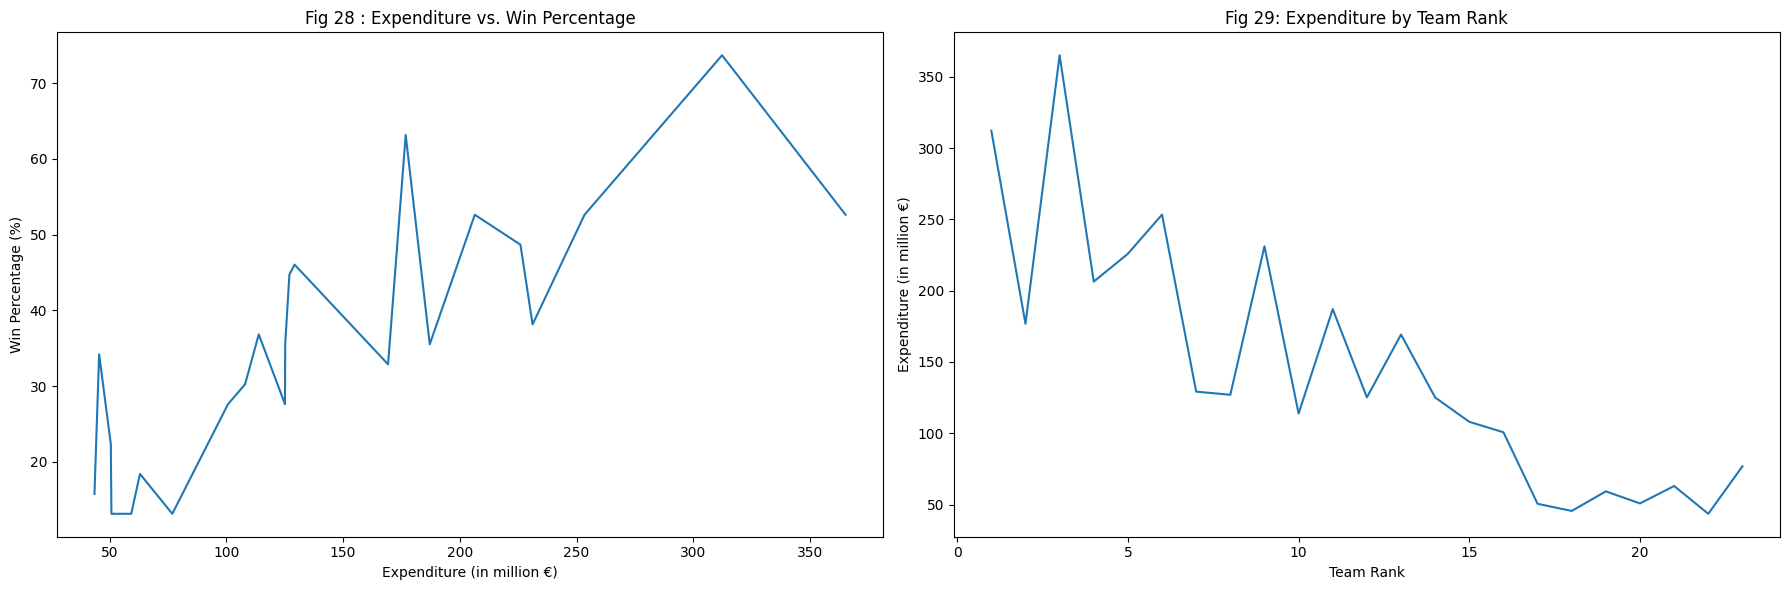

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Expenditure vs. Win Percentage
sns.lineplot(x='Expenditure', y='Win Percentage', data=expenditures_with_performance, ax=axes[0])
axes[0].set_title('Fig 28 : Expenditure vs. Win Percentage')
axes[0].set_xlabel('Expenditure (in million €)')
axes[0].set_ylabel('Win Percentage (%)')
expenditures_with_performance_sorted = expenditures_with_performance.sort_values(by='Rank')

#Expenditure by Team Rank
sns.lineplot(x='Rank', y='Expenditure', data=expenditures_with_performance_sorted, ax=axes[1])
axes[1].set_title('Fig 29: Expenditure by Team Rank')
axes[1].set_xlabel('Team Rank')
axes[1].set_ylabel('Expenditure (in million €)')

plt.tight_layout()
plt.show()


The plots validate the points by the previous plots showing that:
There is a positive trend, where higher expenditures generally correlate with higher win percentages (Fig 28). Teams that invest more tend to perform better in terms of match victories.

Fig 29 shows that top-ranked teams often have higher expenditures, but there are fluctuations, especially in the mid-ranked teams showing their smart investments, which could also show that investing alone is not the key to move up the positions in the standings.


In [ ]:
fig = make_subplots(rows=2, cols=2, subplot_titles=[
    "Income vs. Win Percentage", "Balance vs. Win Percentage",
    "Income vs. Total Points", "Balance vs. Total Points"
])

# Plot 1: Income vs. Win Percentage
fig.add_trace(
    go.Scatter(x=expenditures_with_performance["Income"],
               y=expenditures_with_performance["Win Percentage"],
               mode='markers',
               marker=dict(size=8, color='blue'),
               name="Income vs. Win Percentage"),
    row=1, col=1
)

# Plot 2: Balance vs. Win Percentage
fig.add_trace(
    go.Scatter(x=expenditures_with_performance["Balance"],
               y=expenditures_with_performance["Win Percentage"],
               mode='markers',
               marker=dict(size=8, color='green'),
               name="Balance vs. Win Percentage"),
    row=1, col=2
)

# Plot 3: Income vs. Total Points
fig.add_trace(
    go.Scatter(x=expenditures_with_performance["Income"],
               y=expenditures_with_performance["Total Points"],
               mode='markers',
               marker=dict(size=8, color='orange'),
               name="Income vs. Total Points"),
    row=2, col=1
)

# Plot 4: Balance vs. Total Points
fig.add_trace(
    go.Scatter(x=expenditures_with_performance["Balance"],
               y=expenditures_with_performance["Total Points"],
               mode='markers',
               marker=dict(size=8, color='purple'),
               name="Balance vs. Total Points"),
    row=2, col=2
)

# Update layout with titles and axis labels
fig.update_layout(
    title="Fig 30: inancial Metrics (Income & Balance) vs. Performance (Points & Win Percentage)",
    height=800, width=1000
)
fig.update_xaxes(title_text="Income (in million €)", row=1, col=1)
fig.update_yaxes(title_text="Win Percentage (%)", row=1, col=1)

fig.update_xaxes(title_text="Balance (in million €)", row=1, col=2)
fig.update_yaxes(title_text="Win Percentage (%)", row=1, col=2)

fig.update_xaxes(title_text="Income (in million €)", row=2, col=1)
fig.update_yaxes(title_text="Total Points", row=2, col=1)

fig.update_xaxes(title_text="Balance (in million €)", row=2, col=2)
fig.update_yaxes(title_text="Total Points", row=2, col=2)

# Show the plot
fig.show()


The plot in **Fig 20** shows that there’s no clear trend indicating that higher *income* consistently correlates to a higher *win percentage* or *total points*, suggesting teams that target selling more players are not indicated to play well.

However, on the other hand, a more *negative balance* with teams spending more than income show a trend of higher points and win percentage. The correlation yet is not very strong, highlighting that success may depend on *strategic spending* rather than financial balance alone.


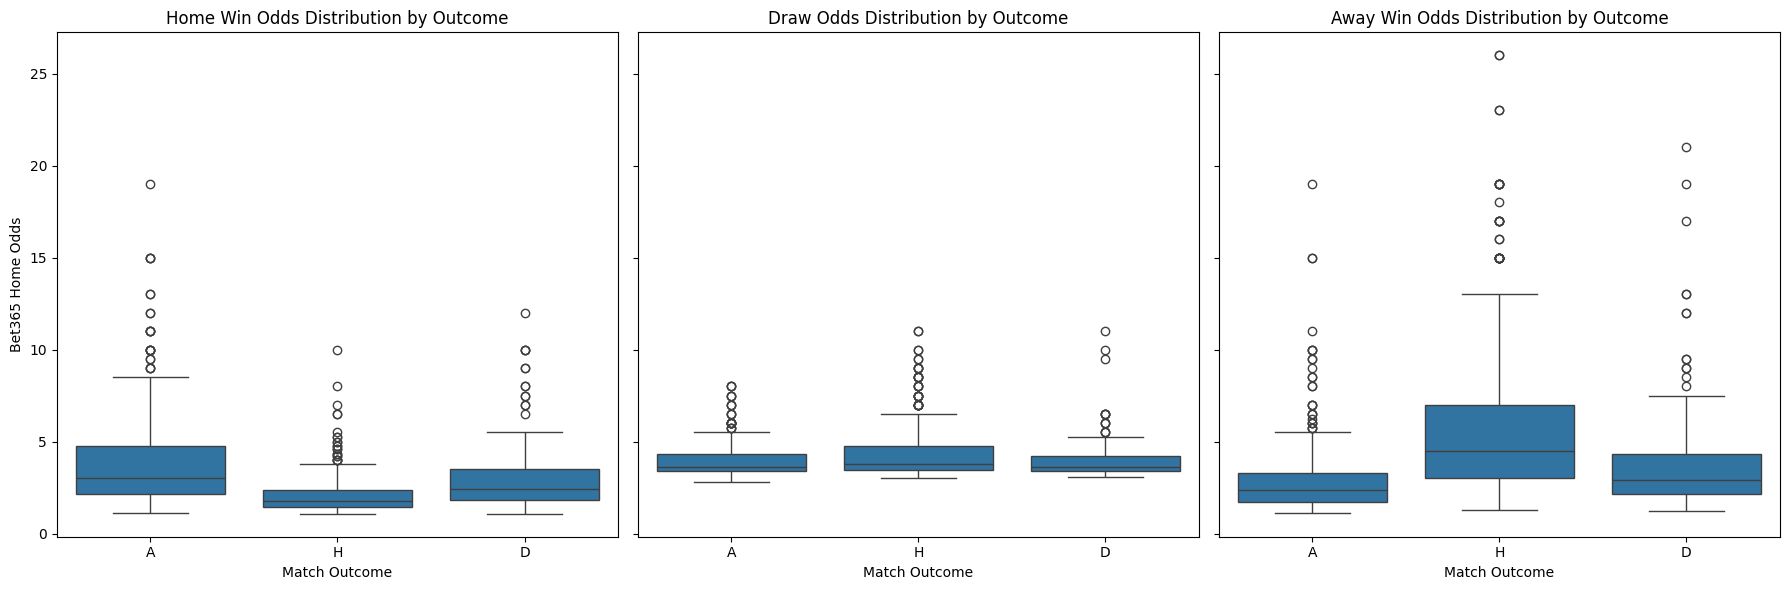

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Home Win Odds Distribution
sns.boxplot(x='FTR', y='B365H', data=seasons_dataset, ax=axes[0])
axes[0].set_title('Fig 31: Home Win Odds Distribution by Outcome')
axes[0].set_xlabel('Match Outcome')
axes[0].set_ylabel('Bet365 Home Odds')

# Draw Odds Distribution
sns.boxplot(x='FTR', y='B365D', data=seasons_dataset, ax=axes[1])
axes[1].set_title('Fig 32: Draw Odds Distribution by Outcome')
axes[1].set_xlabel('Match Outcome')
axes[1].set_ylabel('')

# Away Win Odds Distribution
sns.boxplot(x='FTR', y='B365A', data=seasons_dataset, ax=axes[2])
axes[2].set_title('Fig 33: Away Win Odds Distribution by Outcome')
axes[2].set_xlabel('Match Outcome')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()


This graph shows how betting odds align with match outcomes and proving the theory of home advantage :

Home Win Odds: Games that ended in a home win (H) are more likely to have lower odds for home wins  as shown in fig 33 , showing  confidence in home performance.

Draw Odds: Regardless of the outcome of the match, the draw odds show stable predictions  with very similar odds

Away Win Odds: When confidence in the away team is high, matches that ended in an away win (A) typically have lower odds for away wins

This analysis proves the emphasis on home advantage even in sports betting which relies on data analysis of previous seasons as well and that teams should work to win at home  , regardless of the team they are playing against.



##**What Makes a Winner in the Premier League?**

### Key Takeaway for Building a Winning Team in the Premier League

To succeed in the Premier League, teams should adopt a balanced approach that combines strong in-game performance, disciplined play, adaptability to referee styles, and strategic financial investment:

1. **Prioritize Key Performance Metrics**: Metrics like goals and shots on target are crucial for winning. Leveraging home advantage can enhance these, as crowd support and familiarity often elevate performance at home, so they should aim to win every single match at home, while getting the best possible outcomes away while maintaining their offensive play which would enable them to score.

2. **Maintain Discipline on the Field**: Teams that avoid excessive yellow and red cards perform more consistently, as disciplined play reduces disruptions and keeps the squad intact and allow the teams to perform the manager's tactics better, which is a requirement of winning.

3. **Adapt to Referee Styles**: Referees indirectly influence gameplay. Successful teams should adjust to various officiating styles, minimizing risks of penalties, cards and maintaining control on the field, and trying to decrease the risk of offensive tackles during the matches of referees known for the strictness.

4. **Invest Strategically in Players**: Financial investment in high-impact players  helps in strengthening the squad and improves their performance. While spending doesn’t always ensure success, and teams are advised to do better scouting so they can make better investments in key players that would help in team winning, quality rather than quantity since we found that arrivals number is not the best indicator.

